In [1]:
from matplotlib import pyplot as plt
import numpy as np

import torch

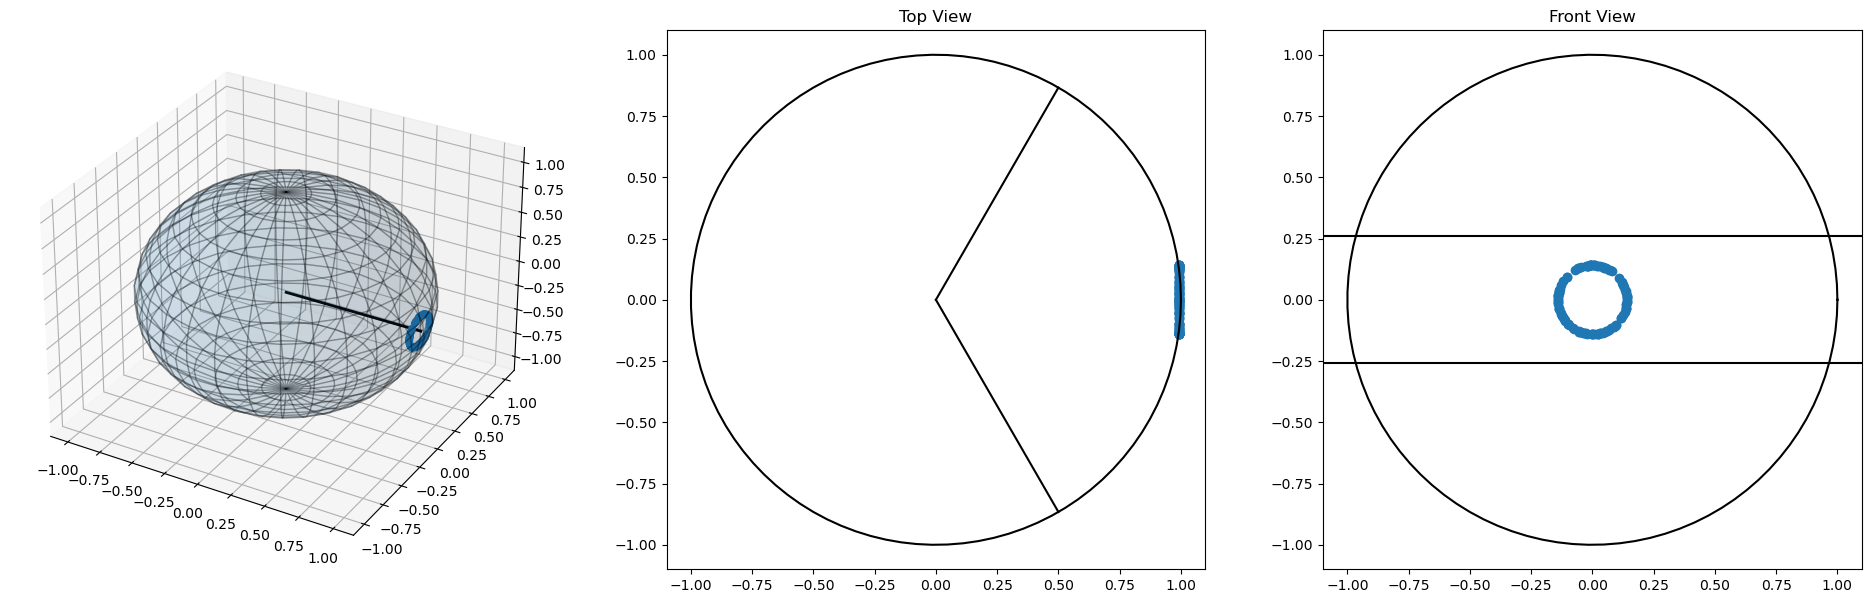

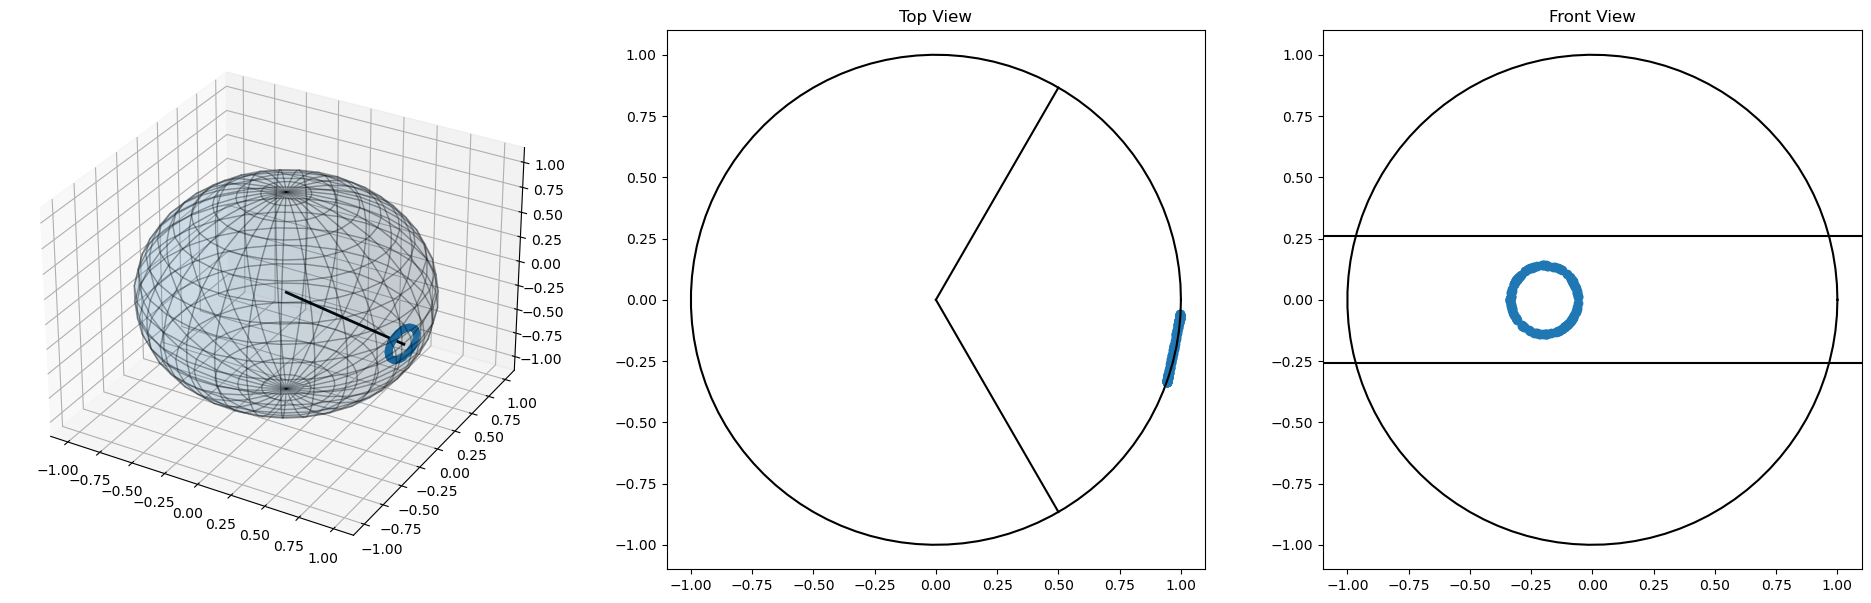

In [2]:
import sample
from functorch import vmap


def _circle(ax, r=1):
    t = np.linspace(0, 2 * np.pi, 100)
    x = r * np.cos(t)
    y = r * np.sin(t)
    ax.plot(x, y, color='black')

def _sphere(ax, r=1):
    u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
    x = r * np.cos(u) * np.sin(v)
    y = r * np.sin(u) * np.sin(v)
    z = r * np.cos(v)
    ax.plot_surface(x, y, z, alpha=0.1, edgecolors=(0, 0, 0, 0.2))

def _ray(ax, theta, r=1):
    ax.plot([0, r * np.cos(theta)], [0, r * np.sin(theta)], color='black')


def plot(v, r=1, d=1, A=torch.eye(3), x=torch.zeros(3)):
    pose = vmap(sample.make_pose)(
        v.reshape(1, 3).expand(2, -1), x.reshape(1, 3).expand(2, -1),
        A.reshape(1, 3, 3).expand(2, -1, -1))

    points, _ = sample.vsample_points(
        torch.Tensor([r, r]), torch.Tensor([d, d]), pose, n=360, k=120)
    points = points[0]

    fig = plt.figure(figsize=(24, 7))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    _sphere(ax, r=r)
    ax.scatter(*points)
    _v = v / np.linalg.norm(v)
    ax.plot([0, _v[0]], [0, _v[1]], [0, _v[2]], color='black', linewidth=2)

    ax = fig.add_subplot(1, 3, 2)
    ax.scatter(*points[:2])
    _ray(ax, np.pi / 3, r=r)
    _ray(ax, -np.pi / 3, r=r)
    _circle(ax, r=r)
    ax.set_title("Top View")
    ax.set_aspect('equal', adjustable='box')

    ax = fig.add_subplot(1, 3, 3)
    ax.scatter(*points[1:])
    ax.axhline(r * np.sin(np.pi / 12), color='black')
    ax.axhline(r * np.sin(-np.pi / 12), color='black')
    _circle(ax, r=r)
    ax.set_title("Front View")
    ax.set_aspect('equal', adjustable='box')


# plot(torch.Tensor([0, 0, 10]))
plot(torch.Tensor([1.01, 0, 0]))
A = torch.Tensor([
    [np.cos(0.2), -np.sin(0.2), 0],
    [np.sin(0.2), np.cos(0.2), 0],
    [0, 0, 1]
])
v = torch.Tensor([1.01, 0, 0])
plot(torch.linalg.matmul(torch.linalg.inv(A), v), A=A)
# plot(torch.Tensor([1, 1, 0]))

In [3]:
from groundtruth import Map3d, Trajectory

map = Map3d('data/map.mat')
traj = Trajectory('data/traj.mat')
